In [23]:
import scipy as sp
from scipy.io import arff
from cStringIO import StringIO
import pandas
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import sklearn.metrics.cluster as sk_cluster_m
import sklearn.metrics as skmetrics
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
import math
from sklearn.metrics import adjusted_rand_score, calinski_harabaz_score
import matplotlib.patches as mpatches


In [24]:
## Function Utils
def rand_centroids(K, X):
    # rand_centroids(K=Int, X=Float_array):
    # Return a numpy array of size K with each element 
    # being a normally random distributed var with mu and sigma calculated 
    # from the mean and std of the data X
    mean, std = np.mean(X, axis=0), np.std(X, axis=0)
    centroids = [np.random.normal(mean, std) for n in range(K)]
    return np.array(centroids)

def euc_distance(X, Y):    
    # euc_distance(X=Float_array, Y=Float_array):
    # Returns an array of euclidean distances, 
    # for the square root of the sum of the square of the differences
    # of array X and array Y
    diff = X - Y[:, np.newaxis]
    squared_diff = diff**2
    sum_squared_diff = squared_diff.sum(axis=2)
    return np.sqrt(sum_squared_diff)

def compute_centroids(K, C, X):
    # compute_centroids(K=Int, C=Float_array, X=Float_array)
    # Compute the centroids for cluster size K, centroid(s) C and data X
    # where a new centroid is calculated as the mean of the data points 
    # which share a common nearest centroid. Repeats until the sum of
    # the euc distances between centroids and points does not change, 
    # then returns the cluster of centroids
    D = euc_distance(X, C)
    CC = np.argmin(D, axis=0)
    C = np.array([new_centroid(k, X, CC) for k in range(K)])
    D2 = euc_distance(X, C)
    if (D.sum() == D2.sum()):
        return C, np.argmin(D2, axis=0)
    else:
        return compute_centroids(K, C, X)

def new_centroid(k, X, CC):
    # Returns a new centroid based on the mean of the points associated with it
    # if no points associated with it, generates a new one
    x = X[CC==k]
    if (len(x) > 0):
        return x.mean(axis=0)
    else: 
        return rand_centroids(1, X)[0]
    
def k_means(K, X):
    # k_means(K=Int, X=Float_array)
    # K-means for clust size K on dataset X using random initialised centroids
    # returns final cluster and predicted labels
    C = rand_centroids(K, X)
    return compute_centroids(K, C, X)

In [31]:
def Bk_means(X, K, k_means_iter=1, log_level=1):
    #Bk_means(X=ndarray, K=Int, k_means_iter=3)
    #X: data to cluster
    #K: number of clusters
    #k_means_iter: number of iteretations on the kmeans call. # of split cluster pairs.
    #log_level: 0 : no messages, 1 print messages 
    
    # Initialize cluster  assigment with all data
    clusters=np.zeros((X.shape[0],1))
    
    print "Computing Bisecting Kmeans with K=",K,"Iterations of internal kmeans splitting:",k_means_iter
    #Set initial number of cluster to 1 and iterate until number of clusters=K
    
    for k in range(1,K):
        if log_level:
            print "*********** NEW ITERATION ************* ", k
        similarity=[]
        potential_new_clusters={}

        if log_level:
            print "*********select cluster to split******"
        
        larger_cluster_index = select_split_cluster(clusters,"larger",log_level) #options: larger, heterogeny, 
        if log_level:
            print "Selected cluster: ", larger_cluster_index
        

        kmeans_data=X[np.where(clusters==larger_cluster_index),:]
        kmeans_data=kmeans_data[0]
        
        if log_level:
            print "*********Generate 2 clusters with Kmeans ******"
            print "*********Best of ", k_means_iter," results ******"
        
        for i in range(0,k_means_iter): 
        #if k_means_iter >1 then we select best k_means split with similarity 
            #potential_new_clusters[i] = KMeans(2, "random",1).fit_predict(kmeans_data)
            #potential_new_clusters[i] = KMeans(2).fit_predict(kmeans_data)
            #call to our kmeans function
            if log_level: 
                print k_means(2,kmeans_data)
            potential_new_clusters[i] = k_means(2,kmeans_data)[1]
            similarity.append(cost_function(kmeans_data,potential_new_clusters[i],log_level))
        
        #Select division based on similarity (min value max similarity)
        selected_division=potential_new_clusters[similarity.index(min(similarity))]
        
        if log_level:
            print "Selected case: ", similarity.index(min(similarity))
        
        new_clusters=selected_division
        new_clusters[np.where(selected_division==1)]=k
        new_clusters[np.where(selected_division==0)]=larger_cluster_index

        
        clusters[np.where(clusters[:]==larger_cluster_index)]=new_clusters

    if log_level:
        print "****** END OF BKmeans *********\n\n\n"    
    return clusters.flatten()

def squares_dist(x):
    #squares_dist(x=ndarray):
    #x: matrix N,M. N rows of data variables. 
    #.  M/2 columns are data features values, M/2 columns are cluster centroid coord. 
    #returns square distances
    
    return (sp.spatial.distance.pdist([x[:x.shape[0]/2],x[x.shape[0]/2:]], 'euclidean'))**2


def cost_function(data_n,clusters_n, log_level=1):
    #cost_function(data_n=ndarray,clusters_n:array)
    #data_n: clustered data
    #clusters_n: clusters association in the data (size: rows of data_n, 1)
    #returns the cost function value
    print data_n.shape[1]
    #Find the centroids of each cluster 
    mus=np.array([data_n[np.where(clusters_n==k)].mean(axis=0) for k in range(len(np.unique(clusters_n)))])
    
    #vector of mu feature values of the associated cluster for each data variable
    mus_complete=np.empty([clusters_n.shape[0],data_n.shape[1]])
    
    for k in range(len(np.unique(clusters_n))):
        
        mus_complete[np.where(clusters_n==k)]=mus[k]
    
    #calculate cost function
    cost_f=sum(np.apply_along_axis(squares_dist, axis=1,arr=np.concatenate((data_n,mus_complete),axis=1))) 
    cost_f=cost_f/data_n.shape[0]
    
    if log_level:
        print "Cost function kmeans split:",cost_f
    return cost_f

def select_split_cluster(clusters, criteria="larger", log_level=1):
    #select_split_cluster (clusters, criteria)
    #clusters: vector of data cluster association (1 column)
    #criteria= "larger". (more option tbi)
    #returns de number of the selected cluster.
    
    selected_key_c=0
    number_of_x=[]
    
    if criteria == "larger":
        for i in np.nditer(np.unique(clusters)):

            number_of_x.append([len(clusters[np.where(clusters==i)]),i])
        
        selected_key_c=number_of_x[number_of_x.index(max(number_of_x))][1]
        
        if log_level:
            print "Number of x in each cluster:", number_of_x

    return selected_key_c


In [26]:
def fcm(data, cluster_n, expo=2, max_iter=100, min_impro=1e-5, display=True,
        initU=None):
    # Data set clustering using fuzzy c-means clustering.
    # The Function finds N_CLUSTER number of clusters in the data set DATA.
    # DATA is size M-by-N, where M is the number of data points and N is the
    # number of coordinates for each data point. The coordinates for each
    # cluster center are returned in the rows of the matrix CENTER.
    # The membership function matrix U contains the grade of membership of
    # each DATA point in each cluster. The values 0 and 1 indicate no
    # membership and full membership respectively. Grades between 0 and 1
    # indicate that the data point has partial membership in a cluster.
    # At each iteration, an objective function is minimized to find the best
    # location for the clusters and its values are returned in OBJ_FCN.

    data_n, in_n = data.shape
    obj_fcn = np.zeros((max_iter, 1))

    # Perform checks
    assert expo != 1, "Exponential parameter must be different from 1"

    U = initfcm(cluster_n, data_n, initU)
    for i in range(max_iter):
        U, center, obj_fcn[i] = stepfcm(data, U, cluster_n, expo)
        if display:
            print("Iteration count {}, obj. fcn = {}".format(i, obj_fcn[i][0]))
        # check termination condition
        if i > 0:
            if np.abs(obj_fcn[i] - obj_fcn[i-1]) < min_impro:
                break

    obj_fcn = obj_fcn[:(i + 1)]  # Actual number of iterations
    labels = np.argmax(U, axis=0)
    return center, U, obj_fcn, labels


def stepfcm(data, U, cluster_n, expo):
    # One step in fuzzy c-mean clustering.
    # performs one iteration of fuzzy c-mean clustering, where
    #
    # DATA: matrix of data to be clustered. (Each row is a data point.)
    # U: partition matrix. (U(i,j) is the MF value of data j in cluster i.)
    # CLUSTER_N: number of clusters.
    # EXPO: exponent (> 1) for the partition matrix.
    # U_NEW: new partition matrix.
    # CENTER: center of clusters. (Each row is a center.)

    # MF matrix after exponential modification
    mf = np.power(U, expo)

    # New center
    center = (np.dot(mf, data)
              / mf.sum(axis=1, keepdims=True) * np.ones((1, data.shape[1])))

    # fill the distance matrix
    dist = distfcm(center, data)

    # objective function
    obj_fcn = np.sum(np.power(dist, 2) * mf)

    # calculate new U, suppose expo != 1
    tmp = np.power(dist, -2/(expo-1))
    U_new = tmp/(np.ones((cluster_n, 1))*np.sum(tmp, axis=0, keepdims=True))

    return U_new, center, obj_fcn


def distfcm(center, data):
    # Distance measure in fuzzy c-mean clustering.
    # Calculates the Euclidean distance between each row in CENTER and each
    # row in DATA, and returns a distance matrix OUT of size M by N, where
    # M and N are row dimensions of CENTER and DATA, respectively, and
    # OUT(I, J) is the distance between CENTER(I,:) and DATA(J,:).
    out = np.zeros((center.shape[0], data.shape[0]))

    # fill the output matrix
    if center.shape[1] > 1:
        for k in range(center.shape[0]):
            out[k, :] = np.sqrt(np.sum(np.power(
                data - np.ones((data.shape[0], 1)) * center[k, :]
                , 2), axis=1))
    else:  # 1-D data
        for k in range(center.shape[0]):
            out[k, :] = np.abs(center[k]-data).transpose()

    return out


def initfcm(cluster_n, data_n, initU=None):
    # Generate initial fuzzy partition matrix for fuzzy c-means clustering.
    # If initU is provided, the function uses initU as the U matrix, otherwise
    # the function randomly generates a fuzzy partition matrix U that is
    # CLUSTER_N by DATA_N, where CLUSTER_N is number of clusters and
    # DATA_N is number of data points. The summation of each column of the
    # generated U is equal to unity, as required by fuzzy c-means clustering.

    if initU is None:
        U = np.random.rand(cluster_n, data_n)
    else:
        assert isinstance(initU, np.ndarray), "initU must be a numpy.ndarray"
        assert (cluster_n, data_n) == initU.shape, \
            "The dimensions of initU must be ({},{})".format(cluster_n, data_n)
        U = initU

    U = U/U.sum(axis=0, keepdims=True)
    return U

In [27]:
def plot_accuracies_BK(accuracies,MAX_K,MAX_K_Iter, gtitle):
    
    traces = []
    for i in range(1,MAX_K_Iter): 
        name1='adjusted_rand_score iter_k-means=' + str(i)
        name2='calinski_score iter_k-means=' + str(i)
        traces.append(Scatter(x=range(2, MAX_K), y=accuracies[:,2*(i-1)], name = name1))
        traces.append(Scatter(x=range(2, MAX_K), y=accuracies[:,2*i-1], name = name2, yaxis='y2'))


    yaxis2=dict(side='right')
    layout = Layout(
        title= gtitle,
        xaxis=dict(title='cluster_size'),
        yaxis=dict(title='adjusted_rand_score'),
        yaxis2=dict(title='calinski_score', overlaying='y', side='right')
    )

    fig = Figure(data=traces, layout=layout)
    plot(fig)

****** Performance evaluation with Pen BASED dataset *********



16


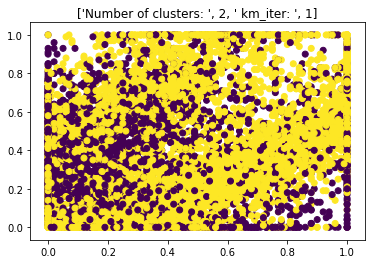

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2979.74443342



16
16


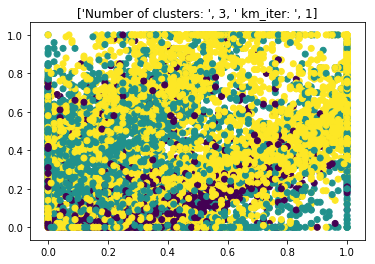

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3017.47036583



16
16
16


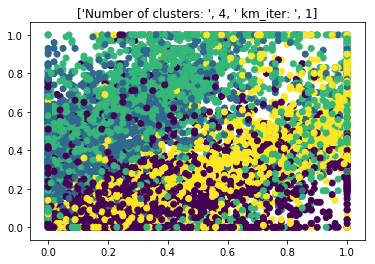

Adjusted rand Index:  0.0
Calinski Harabaz Score:  3260.49590042



16
16
16
16


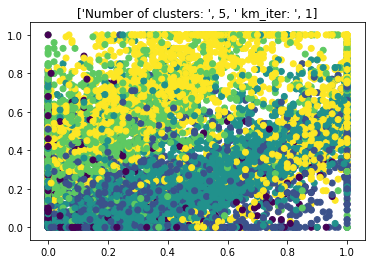

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2685.70628473



16
16
16
16
16


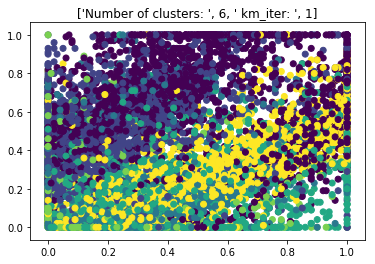

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2940.17034153



16
16
16
16
16
16


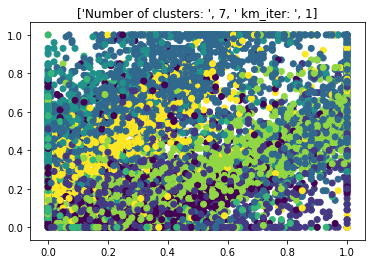

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2629.97675281



16
16
16
16
16
16
16


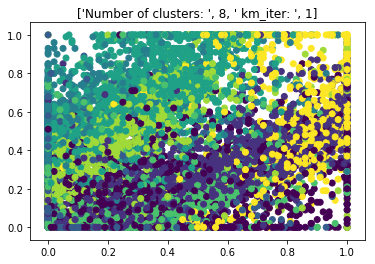

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2496.39338848



16
16
16
16
16
16
16
16


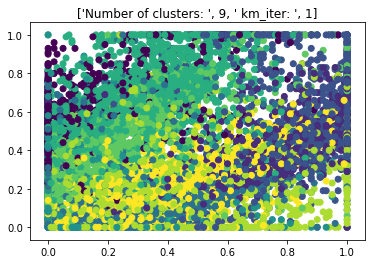

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2580.85770695



16
16
16
16
16
16
16
16
16


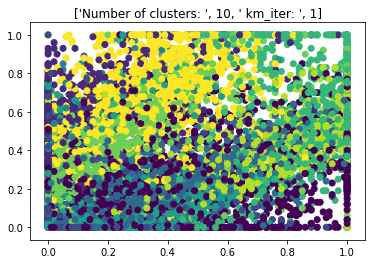

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2337.21955709



16
16
16
16
16
16
16
16
16
16


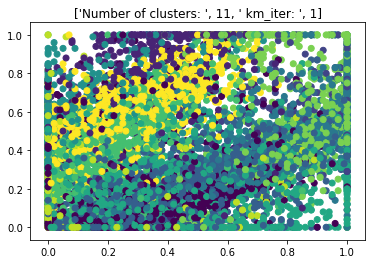

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2320.36752074



16
16
16
16
16
16
16
16
16
16
16


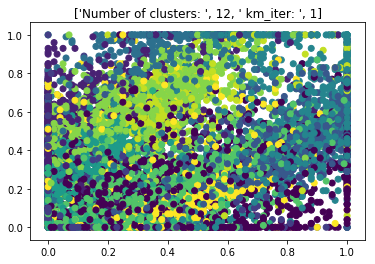

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2191.1389033



16
16
16
16
16
16
16
16
16
16
16
16


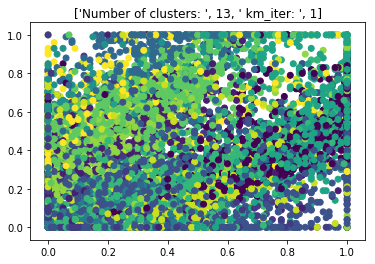

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2138.30998635



16
16
16
16
16
16
16
16
16
16
16
16
16


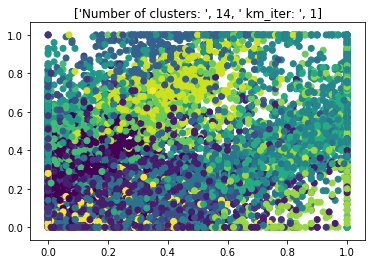

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2067.1526144



16
16
16
16
16
16
16
16
16
16
16
16
16
16


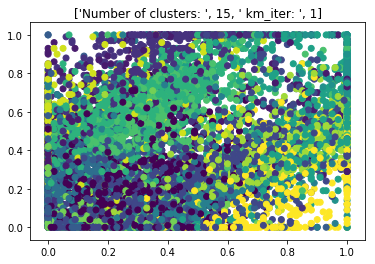

Adjusted rand Index:  0.0
Calinski Harabaz Score:  2073.09799957



16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


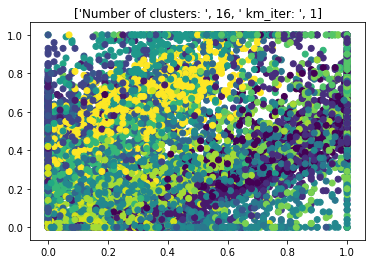

Adjusted rand Index:  0.0
Calinski Harabaz Score:  1929.41684563



16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


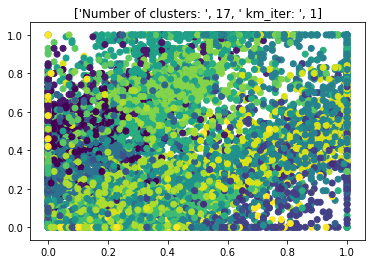

Adjusted rand Index:  0.0
Calinski Harabaz Score:  1873.57222946



16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


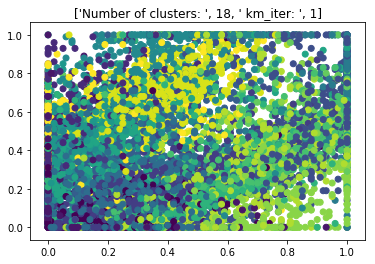

Adjusted rand Index:  0.0
Calinski Harabaz Score:  1899.11925995



16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


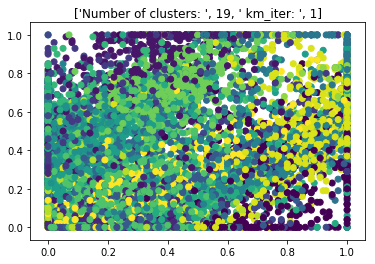

Adjusted rand Index:  0.0
Calinski Harabaz Score:  1853.0947429





In [28]:
#check results

print "****** Performance evaluation with Pen BASED dataset *********\n\n\n" 

#load dataset PEN BASED
f="datasets/pen-based.arff"
data, meta = arff.loadarff(f)

#initialize data ndarrays data_num
#. data_num to cluster 
#. data_label: ground truth classification

data_num=np.zeros((len(data), len(data[0])-1))
data_label=np.zeros((len(data)))

i=0
for d in data:
    data_num[i,:]=[d[0],d[1],d[2],d[3],d[4],d[5],d[6],d[7],d[8],d[9],d[10],d[11],d[12],d[13],d[14],d[15]]
   
    data_label[i]=data[16][0]
    
                    
    i=i+1   


######### SET max_K and max_k_iter TO PLOT Bisecting K-means results for Iris

max_k_iter=2
plt.figure()
max_K=20
accuracies_ar=np.zeros([max_K-2,(max_k_iter-1)*2])


for wanted_K in range(2,max_K):
 
    
    r_array=np.zeros((max_k_iter-1)*2)
    
    for km_iter in range(1,max_k_iter):

        cluster_assignment=Bk_means(data_num,wanted_K,km_iter,0)
        #_,cluster_assignment=k_means(wanted_K, data_num)
        #_,_,_,cluster_assignment=fcm(data_num, wanted_K)
       
        #cluster_assingment=KMeans(wanted_K).fit_predict(data_num)
        plt.title(["Number of clusters: ",wanted_K," km_iter: " , km_iter] )
        #plt.subplot(2,2,wanted_K-1)
        plt.scatter(data_num[:, 0], data_num[:, 2], c=cluster_assignment)
        #plt.text(2, 0.65, ["Adjusted rand Index: " , adjusted_rand_score(data_label.flatten(), cluster_assingment.flatten())])
        #plt.xlabel(meta[0])
        #plt.ylabel(meta[1])
        plt.show()
        rand_score = sk_cluster_m.adjusted_rand_score(data_label.flatten(), cluster_assignment)
        calinski = skmetrics.calinski_harabaz_score(data_num, cluster_assignment)
        r_array[2*(km_iter-1)]=rand_score
        r_array[2*km_iter-1]=calinski
        
        print "Adjusted rand Index: " , sk_cluster_m.adjusted_rand_score(data_label.flatten(), cluster_assignment)
        #print "V measure score: " , sk_cluster_m.v_measure_score(data_label.flatten(), cluster_assingment)
        print "Calinski Harabaz Score: ", skmetrics.calinski_harabaz_score(data_num, cluster_assignment) 
        print "\n\n"
    
    accuracies_ar[wanted_K-2,:]=r_array[:]
    


#print accuracies_ar[:][0]
#plot_accuracies_BK(accuracies_ar,max_K,max_k_iter,"Bisecting K-means accuracy")
#plot_accuracies_BK(accuracies_ar,max_K,max_k_iter,"K-means accuracy")
#plot_accuracies_BK(accuracies_ar,max_K,max_k_iter,"FCM accuracy")

*********** NEW ITERATION *************  1
*********select cluster to split******
Number of x in each cluster: [[10992, array(0.0)]]
Selected cluster:  0.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.30643885,  0.80266187,  0.50586018,  0.91819206,  0.67169534,
         0.83363779,  0.60280106,  0.63279794,  0.58254301,  0.40845167,
         0.55552549,  0.23729903,  0.4972615 ,  0.14314514,  0.4796309 ,
         0.10797779],
       [ 0.50176164,  0.91870378,  0.26726838,  0.72586777,  0.25575033,
         0.40833406,  0.38621575,  0.1838234 ,  0.54941496,  0.23754241,
         0.67419095,  0.50257503,  0.62387125,  0.63614833,  0.46347977,
         0.53942366]]), array([1, 1, 1, ..., 0, 0, 1]))
(10992,)
16
Cost function kmeans split: [ 1.17009127]
(array([[ 0.26353095,  0.8303578 ,  0.39852964,  0.9000679 ,  0.63447898,
         0.70446853,  0.54746148,  0.35714025,  0.29839122,  0.14324106,
         0.16298511,  0.22159833,  0.46673

16
Cost function kmeans split: [ 1.17009167]
Selected case:  0
*********** NEW ITERATION *************  2
*********select cluster to split******
Number of x in each cluster: [[2604, array(0.0)], [8388, array(1.0)]]
Selected cluster:  1.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.1704832 ,  0.79874292,  0.47692714,  0.97394111,  0.69415629,
         0.81724802,  0.56642507,  0.46810495,  0.35833145,  0.15053983,
         0.17387693,  0.09765194,  0.440151  ,  0.17485466,  0.94688939,
         0.20480559],
       [ 0.48740896,  0.86753093,  0.46925248,  0.86395017,  0.4648789 ,
         0.74129988,  0.4936888 ,  0.60017425,  0.69694198,  0.46811465,
         0.82876634,  0.34284196,  0.58417843,  0.19063251,  0.24580066,
         0.07452344]]), array([1, 1, 0, ..., 1, 1, 1]))
(8388,)
16
Cost function kmeans split: [ 0.86821607]
(array([[ 0.48740896,  0.86753093,  0.46925248,  0.86395017,  0.4648789 ,
         0.74129988,  0.4936888 , 

16
Cost function kmeans split: [ 1.19876634]
Selected case:  0
*********** NEW ITERATION *************  2
*********select cluster to split******
Number of x in each cluster: [[2604, array(0.0)], [8388, array(1.0)]]
Selected cluster:  1.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.48740896,  0.86753093,  0.46925248,  0.86395017,  0.4648789 ,
         0.74129988,  0.4936888 ,  0.60017425,  0.69694198,  0.46811465,
         0.82876634,  0.34284196,  0.58417843,  0.19063251,  0.24580066,
         0.07452344],
       [ 0.1704832 ,  0.79874292,  0.47692714,  0.97394111,  0.69415629,
         0.81724802,  0.56642507,  0.46810495,  0.35833145,  0.15053983,
         0.17387693,  0.09765194,  0.440151  ,  0.17485466,  0.94688939,
         0.20480559]]), array([0, 0, 1, ..., 0, 0, 0]))
(8388,)
16
Cost function kmeans split: [ 0.86821607]
(array([[ 0.48740896,  0.86753093,  0.46925248,  0.86395017,  0.4648789 ,
         0.74129988,  0.4936888 , 

Iteration count 96, obj. fcn = 4003.81029598
Iteration count 97, obj. fcn = 4003.80308139
Iteration count 98, obj. fcn = 4003.79801519
Iteration count 99, obj. fcn = 4003.79446173
*********** NEW ITERATION *************  1
*********select cluster to split******
Number of x in each cluster: [[10992, array(0.0)]]
Selected cluster:  0.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.50176164,  0.91870378,  0.26726838,  0.72586777,  0.25575033,
         0.40833406,  0.38621575,  0.1838234 ,  0.54941496,  0.23754241,
         0.67419095,  0.50257503,  0.62387125,  0.63614833,  0.46347977,
         0.53942366],
       [ 0.30643885,  0.80266187,  0.50586018,  0.91819206,  0.67169534,
         0.83363779,  0.60280106,  0.63279794,  0.58254301,  0.40845167,
         0.55552549,  0.23729903,  0.4972615 ,  0.14314514,  0.4796309 ,
         0.10797779]]), array([0, 0, 0, ..., 1, 1, 0]))
(10992,)
16
Cost function kmeans split: [ 1.16903056]
(array([[

Iteration count 2, obj. fcn = 3269.76396005
Iteration count 3, obj. fcn = 3269.76161735
Iteration count 4, obj. fcn = 3269.7602588
Iteration count 5, obj. fcn = 3269.75903716
Iteration count 6, obj. fcn = 3269.75774521
Iteration count 7, obj. fcn = 3269.75630493
Iteration count 8, obj. fcn = 3269.75467063
Iteration count 9, obj. fcn = 3269.75280341
Iteration count 10, obj. fcn = 3269.7506626
Iteration count 11, obj. fcn = 3269.74820222
Iteration count 12, obj. fcn = 3269.74536877
Iteration count 13, obj. fcn = 3269.74209934
Iteration count 14, obj. fcn = 3269.7383197
Iteration count 15, obj. fcn = 3269.73394186
Iteration count 16, obj. fcn = 3269.72886135
Iteration count 17, obj. fcn = 3269.72295366
Iteration count 18, obj. fcn = 3269.71606996
Iteration count 19, obj. fcn = 3269.70803173
Iteration count 20, obj. fcn = 3269.6986239
Iteration count 21, obj. fcn = 3269.68758617
Iteration count 22, obj. fcn = 3269.67460187
Iteration count 23, obj. fcn = 3269.65928344
Iteration count 24, ob

(8388,)
16
Cost function kmeans split: [ 0.86821607]
Selected case:  0
*********** NEW ITERATION *************  3
*********select cluster to split******
Number of x in each cluster: [[2604, array(0.0)], [5739, array(1.0)], [2649, array(2.0)]]
Selected cluster:  1.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.28274988,  0.82502581,  0.24763961,  0.77124355,  0.33024871,
         0.6952229 ,  0.65934303,  0.6786626 ,  0.84956359,  0.64114969,
         0.81053027,  0.55570155,  0.65702018,  0.27287658,  0.54137494,
         0.00231347],
       [ 0.60828714,  0.89263581,  0.60014412,  0.91870565,  0.54439579,
         0.76851441,  0.39584812,  0.55381652,  0.60679878,  0.36591463,
         0.83953714,  0.21712029,  0.54115576,  0.14205654,  0.07122506,
         0.11717295]]), array([1, 0, 0, ..., 1, 1, 0]))
(5739,)
16
Cost function kmeans split: [ 0.75580752]
(array([[ 0.60828714,  0.89263581,  0.60014412,  0.91870565,  0.54439579,
      

Iteration count 47, obj. fcn = 2721.98554962
Iteration count 48, obj. fcn = 2720.81554206
Iteration count 49, obj. fcn = 2719.06845254
Iteration count 50, obj. fcn = 2716.49435331
Iteration count 51, obj. fcn = 2712.86608244
Iteration count 52, obj. fcn = 2708.20251465
Iteration count 53, obj. fcn = 2703.06742896
Iteration count 54, obj. fcn = 2698.49731217
Iteration count 55, obj. fcn = 2695.26069517
Iteration count 56, obj. fcn = 2693.31136562
Iteration count 57, obj. fcn = 2692.14331609
Iteration count 58, obj. fcn = 2691.30199045
Iteration count 59, obj. fcn = 2690.51048211
Iteration count 60, obj. fcn = 2689.60766586
Iteration count 61, obj. fcn = 2688.48920194
Iteration count 62, obj. fcn = 2687.08377345
Iteration count 63, obj. fcn = 2685.35449892
Iteration count 64, obj. fcn = 2683.31522416
Iteration count 65, obj. fcn = 2681.04936352
Iteration count 66, obj. fcn = 2678.7125209
Iteration count 67, obj. fcn = 2676.50136328
Iteration count 68, obj. fcn = 2674.59244855
Iteration c

16
Cost function kmeans split: [ 0.64050437]
(array([[ 0.52073108,  0.85714916,  0.6236701 ,  0.93996326,  0.65244673,
         0.83756429,  0.53138134,  0.67229978,  0.71975018,  0.50488979,
         0.84759368,  0.25519104,  0.51491918,  0.07831741,  0.0499155 ,
         0.07529023],
       [ 0.10561668,  0.66546584,  0.28488021,  0.74067436,  0.6383496 ,
         0.86086957,  0.8728394 ,  0.90491571,  0.80512866,  0.75228926,
         0.72207631,  0.52100266,  0.57960071,  0.25067436,  0.48830524,
         0.00704525]]), array([1, 1, 1, ..., 0, 0, 0]))
(3849,)
16
Cost function kmeans split: [ 0.64050437]
(array([[ 0.52073108,  0.85714916,  0.6236701 ,  0.93996326,  0.65244673,
         0.83756429,  0.53138134,  0.67229978,  0.71975018,  0.50488979,
         0.84759368,  0.25519104,  0.51491918,  0.07831741,  0.0499155 ,
         0.07529023],
       [ 0.10561668,  0.66546584,  0.28488021,  0.74067436,  0.6383496 ,
         0.86086957,  0.8728394 ,  0.90491571,  0.80512866,  0.7522892

Iteration count 65, obj. fcn = 2288.7937844
Iteration count 66, obj. fcn = 2288.67380043
Iteration count 67, obj. fcn = 2288.53280892
Iteration count 68, obj. fcn = 2288.36407229
Iteration count 69, obj. fcn = 2288.16030234
Iteration count 70, obj. fcn = 2287.91361064
Iteration count 71, obj. fcn = 2287.61573475
Iteration count 72, obj. fcn = 2287.25857435
Iteration count 73, obj. fcn = 2286.83500093
Iteration count 74, obj. fcn = 2286.33972796
Iteration count 75, obj. fcn = 2285.76976176
Iteration count 76, obj. fcn = 2285.12374803
Iteration count 77, obj. fcn = 2284.39970687
Iteration count 78, obj. fcn = 2283.59152623
Iteration count 79, obj. fcn = 2282.68605325
Iteration count 80, obj. fcn = 2281.66387755
Iteration count 81, obj. fcn = 2280.50682795
Iteration count 82, obj. fcn = 2279.21303925
Iteration count 83, obj. fcn = 2277.81572187
Iteration count 84, obj. fcn = 2276.39473825
Iteration count 85, obj. fcn = 2275.06565316
Iteration count 86, obj. fcn = 2273.94081454
Iteration c

(3209,)
16
Cost function kmeans split: [ 0.53417904]
(array([[ 0.0617616 ,  0.64842827,  0.27362869,  0.72958861,  0.67112869,
         0.86738397,  0.91148734,  0.92517932,  0.80734177,  0.75804852,
         0.71015823,  0.52772152,  0.56904008,  0.25591772,  0.47768987,
         0.00207806],
       [ 0.4314728 ,  0.84858027,  0.616046  ,  0.93803184,  0.74991597,
         0.84857143,  0.5992835 ,  0.69356479,  0.7498452 ,  0.50484299,
         0.86254755,  0.24490049,  0.51026537,  0.0648828 ,  0.0296904 ,
         0.07862893]]), array([0, 0, 0, ..., 1, 1, 1]))
(3209,)
16
Cost function kmeans split: [ 0.53417904]
Selected case:  0
*********** NEW ITERATION *************  5
*********select cluster to split******
Number of x in each cluster: [[2604, array(0.0)], [2255, array(1.0)], [2649, array(2.0)], [2530, array(3.0)], [954, array(4.0)]]
Selected cluster:  2.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.19769905,  0.75303871,  0.422

Iteration count 32, obj. fcn = 2043.16313766
Iteration count 33, obj. fcn = 2043.03133427
Iteration count 34, obj. fcn = 2042.84380171
Iteration count 35, obj. fcn = 2042.56983434
Iteration count 36, obj. fcn = 2042.15870846
Iteration count 37, obj. fcn = 2041.52604061
Iteration count 38, obj. fcn = 2040.53346357
Iteration count 39, obj. fcn = 2038.96769866
Iteration count 40, obj. fcn = 2036.55371512
Iteration count 41, obj. fcn = 2033.09972334
Iteration count 42, obj. fcn = 2028.86320417
Iteration count 43, obj. fcn = 2024.78096077
Iteration count 44, obj. fcn = 2021.78812614
Iteration count 45, obj. fcn = 2019.95582604
Iteration count 46, obj. fcn = 2018.83240324
Iteration count 47, obj. fcn = 2018.04679549
Iteration count 48, obj. fcn = 2017.39061767
Iteration count 49, obj. fcn = 2016.73460715
Iteration count 50, obj. fcn = 2015.98510071
Iteration count 51, obj. fcn = 2015.07193634
Iteration count 52, obj. fcn = 2013.94939342
Iteration count 53, obj. fcn = 2012.60639778
Iteration 

16
Cost function kmeans split: [ 0.9752876]
Selected case:  1
*********** NEW ITERATION *************  4
*********select cluster to split******
Number of x in each cluster: [[3839, array(0.0)], [2096, array(1.0)], [2555, array(2.0)], [2502, array(3.0)]]
Selected cluster:  0.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.51940612,  0.85675028,  0.62347842,  0.93995942,  0.65391737,
         0.8381446 ,  0.5332239 ,  0.67335301,  0.72167835,  0.50616747,
         0.84819993,  0.25548506,  0.51433051,  0.07756179,  0.048827  ,
         0.07502767],
       [ 0.10552305,  0.66487589,  0.28491135,  0.74013298,  0.63846631,
         0.86042553,  0.87295213,  0.90468972,  0.8052305 ,  0.75245567,
         0.72171986,  0.5214273 ,  0.57914894,  0.25111702,  0.48845745,
         0.00759752]]), array([1, 1, 1, ..., 0, 0, 0]))
(3839,)
16
Cost function kmeans split: [ 0.63820672]
(array([[ 0.51922878,  0.85672325,  0.62358303,  0.93993727,  0.65415

Cost function kmeans split: [ 0.43739232]
(array([[ 0.85052305,  0.96705674,  0.48035461,  0.87238475,  0.15950355,
         0.58368794,  0.08042553,  0.25449468,  0.40132979,  0.02587766,
         0.82080674,  0.14239362,  0.64320922,  0.35473404,  0.23082447,
         0.31868794],
       [ 0.43366736,  0.99270661,  0.21653926,  0.78581612,  0.02580579,
         0.49399793,  0.40783058,  0.38251033,  0.8693595 ,  0.4752376 ,
         0.88318182,  0.60705579,  0.73171488,  0.32088843,  0.65002066,
         0.00103306]]), array([0, 0, 0, ..., 0, 0, 1]))
(2096,)
16
Cost function kmeans split: [ 0.43739237]
(array([[ 0.85052305,  0.96705674,  0.48035461,  0.87238475,  0.15950355,
         0.58368794,  0.08042553,  0.25449468,  0.40132979,  0.02587766,
         0.82080674,  0.14239362,  0.64320922,  0.35473404,  0.23082447,
         0.31868794],
       [ 0.43366736,  0.99270661,  0.21653926,  0.78581612,  0.02580579,
         0.49399793,  0.40783058,  0.38251033,  0.8693595 ,  0.4752376 ,


(7163,)
16
Cost function kmeans split: [ 0.9410641]
(array([[ 0.39065165,  0.7965004 ,  0.52242961,  0.87966479,  0.65437919,
         0.84773666,  0.64406543,  0.74858407,  0.75683561,  0.58838563,
         0.81412711,  0.33882006,  0.53103245,  0.12611692,  0.17475731,
         0.05171091],
       [ 0.52436517,  0.93384683,  0.28807804,  0.72272277,  0.17506115,
         0.39288876,  0.32969715,  0.21327024,  0.66575713,  0.27993593,
         0.87129004,  0.4997583 ,  0.66415842,  0.56549505,  0.30609202,
         0.38651718]]), array([1, 1, 1, ..., 0, 0, 1]))
(7163,)
16
Cost function kmeans split: [ 0.9410641]
Selected case:  1
*********** NEW ITERATION *************  3
*********select cluster to split******
Number of x in each cluster: [[3829, array(0.0)], [3434, array(1.0)], [3729, array(2.0)]]
Selected cluster:  0.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.46819881,  0.89004248,  0.22791844,  0.73665251,  0.49829227,
        

Cost function kmeans split: [ 0.41919818]
Selected case:  0
*********** NEW ITERATION *************  7
*********select cluster to split******
Number of x in each cluster: [[1203, array(0.0)], [1337, array(1.0)], [2621, array(2.0)], [1175, array(3.0)], [1108, array(4.0)], [2097, array(5.0)], [1451, array(6.0)]]
Selected cluster:  2.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.28748768,  0.83883621,  0.6404064 ,  0.94817118,  0.84781404,
         0.87176108,  0.54589286,  0.65203202,  0.713633  ,  0.45440887,
         0.88379926,  0.22371921,  0.52150246,  0.06294951,  0.03637931,
         0.08791872],
       [ 0.87152457,  0.87898696,  0.59404213,  0.92873621,  0.35602808,
         0.79565697,  0.54373119,  0.72787362,  0.77107322,  0.61878636,
         0.80573721,  0.31689067,  0.49810431,  0.08608826,  0.0567001 ,
         0.04086259]]), array([0, 0, 1, ..., 1, 1, 1]))
(2621,)
16
Cost function kmeans split: [ 0.48038419]
(array([[ 0

Iteration count 28, obj. fcn = 1634.79085148
Iteration count 29, obj. fcn = 1634.77264986
Iteration count 30, obj. fcn = 1634.74990471
Iteration count 31, obj. fcn = 1634.7210667
Iteration count 32, obj. fcn = 1634.68388319
Iteration count 33, obj. fcn = 1634.63499831
Iteration count 34, obj. fcn = 1634.56928171
Iteration count 35, obj. fcn = 1634.47867395
Iteration count 36, obj. fcn = 1634.3501545
Iteration count 37, obj. fcn = 1634.16209765
Iteration count 38, obj. fcn = 1633.87768051
Iteration count 39, obj. fcn = 1633.4331304
Iteration count 40, obj. fcn = 1632.71821525
Iteration count 41, obj. fcn = 1631.55094244
Iteration count 42, obj. fcn = 1629.67409653
Iteration count 43, obj. fcn = 1626.87471182
Iteration count 44, obj. fcn = 1623.35345346
Iteration count 45, obj. fcn = 1619.96684568
Iteration count 46, obj. fcn = 1617.46483416
Iteration count 47, obj. fcn = 1615.75167713
Iteration count 48, obj. fcn = 1614.43917451
Iteration count 49, obj. fcn = 1613.3015044
Iteration coun

(array([[ 0.32236137,  0.78947975,  0.51502492,  0.87649221,  0.72656075,
         0.85409657,  0.69135514,  0.76190654,  0.76684424,  0.57965732,
         0.81758567,  0.32843925,  0.52766355,  0.12128037,  0.16198754,
         0.05601869],
       [ 0.69689996,  0.96659945,  0.41115461,  0.84803084,  0.13273231,
         0.5981297 ,  0.24279557,  0.39489126,  0.60821669,  0.32653618,
         0.84295769,  0.36112297,  0.65591143,  0.27865955,  0.35218268,
         0.09801107]]), array([1, 0, 1, ..., 0, 0, 1]))
(5739,)
16
Cost function kmeans split: [ 0.75580752]
Selected case:  0
*********** NEW ITERATION *************  4
*********select cluster to split******
Number of x in each cluster: [[2649, array(0.0)], [2604, array(1.0)], [2530, array(2.0)], [3209, array(3.0)]]
Selected cluster:  3.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.06174004,  0.64984277,  0.27366876,  0.72965409,  0.67246331,
         0.8677044 ,  0.90848008,  0.92

(array([[ 0.8564726 ,  0.88407534,  0.55809932,  0.91458904,  0.46503425,
         0.77803082,  0.75125   ,  0.80375   ,  0.87707192,  0.63976027,
         0.82910959,  0.29193493,  0.47844178,  0.05542808,  0.00568493,
         0.04664384],
       [ 0.28427887,  0.83608618,  0.63750449,  0.94693597,  0.8490006 ,
         0.87297427,  0.5467684 ,  0.65427289,  0.70675045,  0.45700778,
         0.87405745,  0.22732496,  0.52071813,  0.0677319 ,  0.03788749,
         0.09008977]]), array([1, 1, 0, ..., 0, 0, 0]))
(2255,)
16
Cost function kmeans split: [ 0.47675175]
(array([[ 0.28427887,  0.83608618,  0.63750449,  0.94693597,  0.8490006 ,
         0.87297427,  0.5467684 ,  0.65427289,  0.70675045,  0.45700778,
         0.87405745,  0.22732496,  0.52071813,  0.0677319 ,  0.03788749,
         0.09008977],
       [ 0.8564726 ,  0.88407534,  0.55809932,  0.91458904,  0.46503425,
         0.77803082,  0.75125   ,  0.80375   ,  0.87707192,  0.63976027,
         0.82910959,  0.29193493,  0.47844

Iteration count 63, obj. fcn = 1457.64330375
Iteration count 64, obj. fcn = 1456.87848445
Iteration count 65, obj. fcn = 1456.27532294
Iteration count 66, obj. fcn = 1455.75839078
Iteration count 67, obj. fcn = 1455.25660041
Iteration count 68, obj. fcn = 1454.71017814
Iteration count 69, obj. fcn = 1454.06872563
Iteration count 70, obj. fcn = 1453.28374228
Iteration count 71, obj. fcn = 1452.29421857
Iteration count 72, obj. fcn = 1451.0002205
Iteration count 73, obj. fcn = 1449.22771517
Iteration count 74, obj. fcn = 1446.73593214
Iteration count 75, obj. fcn = 1443.42539465
Iteration count 76, obj. fcn = 1439.82042741
Iteration count 77, obj. fcn = 1437.02251361
Iteration count 78, obj. fcn = 1435.48989314
Iteration count 79, obj. fcn = 1434.76741855
Iteration count 80, obj. fcn = 1434.39681006
Iteration count 81, obj. fcn = 1434.18021559
Iteration count 82, obj. fcn = 1434.0441431
Iteration count 83, obj. fcn = 1433.95581418
Iteration count 84, obj. fcn = 1433.89732921
Iteration co

Cost function kmeans split: [ 0.53417904]
Selected case:  1
*********** NEW ITERATION *************  5
*********select cluster to split******
Number of x in each cluster: [[2530, array(0.0)], [2604, array(1.0)], [2649, array(2.0)], [953, array(3.0)], [2256, array(4.0)]]
Selected cluster:  2.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.141375  ,  0.847625  ,  0.53533594,  0.97607813,  0.78753125,
         0.82466406,  0.6896875 ,  0.46735938,  0.52678906,  0.12064063,
         0.23409375,  0.11596094,  0.33164844,  0.29495312,  0.90682813,
         0.34935937],
       [ 0.19769905,  0.75303871,  0.42231556,  0.97194302,  0.60685172,
         0.8103141 ,  0.45117604,  0.46880205,  0.20082542,  0.17849525,
         0.11757487,  0.08053324,  0.54159971,  0.06256392,  0.98434624,
         0.06964938]]), array([1, 1, 1, ..., 0, 0, 1]))
(2649,)
16
Cost function kmeans split: [ 0.41517332]
(array([[ 0.141375  ,  0.847625  ,  0.53533594,  0.9

(1676,)
16
Cost function kmeans split: [ 0.35725292]
(array([[ 0.24374895,  0.83667228,  0.57925864,  0.98864364,  0.87155013,
         0.84486099,  0.64912384,  0.58820556,  0.79622578,  0.39484414,
         0.89909857,  0.16866049,  0.49636057,  0.05447346,  0.03068239,
         0.09957035],
       [ 0.38509202,  0.83404908,  0.78141104,  0.84474438,  0.79128834,
         0.94208589,  0.29554192,  0.81525562,  0.4894274 ,  0.61022495,
         0.81190184,  0.37235174,  0.5803681 ,  0.10067485,  0.05597137,
         0.06615542]]), array([0, 0, 0, ..., 1, 1, 1]))
(1676,)
16
Cost function kmeans split: [ 0.35728797]
Selected case:  0
*********** NEW ITERATION *************  10
*********select cluster to split******
Number of x in each cluster: [[1222, array(0.0)], [1364, array(1.0)], [1280, array(2.0)], [953, array(3.0)], [580, array(4.0)], [1369, array(5.0)], [1240, array(6.0)], [1308, array(7.0)], [480, array(8.0)], [1196, array(9.0)]]
Selected cluster:  5.0
*********Generate 2 cluste

Iteration count 74, obj. fcn = 1337.71690648
Iteration count 75, obj. fcn = 1337.66510145
Iteration count 76, obj. fcn = 1337.60401759
Iteration count 77, obj. fcn = 1337.53002104
Iteration count 78, obj. fcn = 1337.43791786
Iteration count 79, obj. fcn = 1337.32020389
Iteration count 80, obj. fcn = 1337.16591051
Iteration count 81, obj. fcn = 1336.95880627
Iteration count 82, obj. fcn = 1336.67453239
Iteration count 83, obj. fcn = 1336.27584251
Iteration count 84, obj. fcn = 1335.70413616
Iteration count 85, obj. fcn = 1334.86337184
Iteration count 86, obj. fcn = 1333.59025971
Iteration count 87, obj. fcn = 1331.61584126
Iteration count 88, obj. fcn = 1328.60585993
Iteration count 89, obj. fcn = 1324.56994957
Iteration count 90, obj. fcn = 1320.5779257
Iteration count 91, obj. fcn = 1317.97314841
Iteration count 92, obj. fcn = 1316.6336821
Iteration count 93, obj. fcn = 1315.84798245
Iteration count 94, obj. fcn = 1315.28151478
Iteration count 95, obj. fcn = 1314.83360282
Iteration co

16
Cost function kmeans split: [ 0.53417744]
Selected case:  2
*********** NEW ITERATION *************  5
*********select cluster to split******
Number of x in each cluster: [[2604, array(0.0)], [2649, array(1.0)], [2530, array(2.0)], [948, array(3.0)], [2261, array(4.0)]]
Selected cluster:  1.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.19769905,  0.75303871,  0.42231556,  0.97194302,  0.60685172,
         0.8103141 ,  0.45117604,  0.46880205,  0.20082542,  0.17849525,
         0.11757487,  0.08053324,  0.54159971,  0.06256392,  0.98434624,
         0.06964938],
       [ 0.141375  ,  0.847625  ,  0.53533594,  0.97607813,  0.78753125,
         0.82466406,  0.6896875 ,  0.46735938,  0.52678906,  0.12064063,
         0.23409375,  0.11596094,  0.33164844,  0.29495312,  0.90682813,
         0.34935937]]), array([0, 0, 0, ..., 1, 1, 0]))
(2649,)
16
Cost function kmeans split: [ 0.4151657]
(array([[ 0.19769905,  0.75303871,  0.42231556,  0

16
Cost function kmeans split: [ 0.35736737]
(array([[ 0.24596667,  0.835625  ,  0.58143333,  0.98700833,  0.87180833,
         0.84588333,  0.65005   ,  0.59005833,  0.7949    ,  0.39639167,
         0.895225  ,  0.16981667,  0.49330833,  0.05523333,  0.03058333,
         0.09908333],
       [ 0.37781971,  0.83771488,  0.77406709,  0.84352201,  0.79205451,
         0.94169811,  0.28551363,  0.8190566 ,  0.48073375,  0.61249476,
         0.82127883,  0.37620545,  0.59188679,  0.10073375,  0.05683438,
         0.06633124]]), array([0, 0, 0, ..., 1, 1, 1]))
(1677,)
16
Cost function kmeans split: [ 0.35736737]
Selected case:  0
*********** NEW ITERATION *************  10
*********select cluster to split******
Number of x in each cluster: [[1240, array(0.0)], [1369, array(1.0)], [1308, array(2.0)], [948, array(3.0)], [1200, array(4.0)], [1280, array(5.0)], [1364, array(6.0)], [1222, array(7.0)], [584, array(8.0)], [477, array(9.0)]]
Selected cluster:  1.0
*********Generate 2 clusters with 

Iteration count 25, obj. fcn = 1257.57395936
Iteration count 26, obj. fcn = 1257.56913583
Iteration count 27, obj. fcn = 1257.56337166
Iteration count 28, obj. fcn = 1257.55643214
Iteration count 29, obj. fcn = 1257.54800527
Iteration count 30, obj. fcn = 1257.53766884
Iteration count 31, obj. fcn = 1257.52484002
Iteration count 32, obj. fcn = 1257.50869673
Iteration count 33, obj. fcn = 1257.48805149
Iteration count 34, obj. fcn = 1257.46114416
Iteration count 35, obj. fcn = 1257.425292
Iteration count 36, obj. fcn = 1257.37628225
Iteration count 37, obj. fcn = 1257.30728819
Iteration count 38, obj. fcn = 1257.2068847
Iteration count 39, obj. fcn = 1257.05534293
Iteration count 40, obj. fcn = 1256.81767904
Iteration count 41, obj. fcn = 1256.43102126
Iteration count 42, obj. fcn = 1255.78449475
Iteration count 43, obj. fcn = 1254.70107888
Iteration count 44, obj. fcn = 1252.97936865
Iteration count 45, obj. fcn = 1250.62930233
Iteration count 46, obj. fcn = 1248.18661957
Iteration cou

(5739,)
16
Cost function kmeans split: [ 0.75580752]
(array([[ 0.32236137,  0.78947975,  0.51502492,  0.87649221,  0.72656075,
         0.85409657,  0.69135514,  0.76190654,  0.76684424,  0.57965732,
         0.81758567,  0.32843925,  0.52766355,  0.12128037,  0.16198754,
         0.05601869],
       [ 0.69689996,  0.96659945,  0.41115461,  0.84803084,  0.13273231,
         0.5981297 ,  0.24279557,  0.39489126,  0.60821669,  0.32653618,
         0.84295769,  0.36112297,  0.65591143,  0.27865955,  0.35218268,
         0.09801107]]), array([1, 0, 1, ..., 0, 0, 1]))
(5739,)
16
Cost function kmeans split: [ 0.75580752]
Selected case:  0
*********** NEW ITERATION *************  4
*********select cluster to split******
Number of x in each cluster: [[2604, array(0.0)], [2649, array(1.0)], [2530, array(2.0)], [3209, array(3.0)]]
Selected cluster:  3.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.06174004,  0.64984277,  0.27366876,  0.72965409,

(2530,)
16
Cost function kmeans split: [ 0.46941885]
Selected case:  0
*********** NEW ITERATION *************  8
*********select cluster to split******
Number of x in each cluster: [[1240, array(0.0)], [1280, array(1.0)], [1308, array(2.0)], [954, array(3.0)], [2255, array(4.0)], [1369, array(5.0)], [1364, array(6.0)], [1222, array(7.0)]]
Selected cluster:  4.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.28427887,  0.83608618,  0.63750449,  0.94693597,  0.8490006 ,
         0.87297427,  0.5467684 ,  0.65427289,  0.70675045,  0.45700778,
         0.87405745,  0.22732496,  0.52071813,  0.0677319 ,  0.03788749,
         0.09008977],
       [ 0.8564726 ,  0.88407534,  0.55809932,  0.91458904,  0.46503425,
         0.77803082,  0.75125   ,  0.80375   ,  0.87707192,  0.63976027,
         0.82910959,  0.29193493,  0.47844178,  0.05542808,  0.00568493,
         0.04664384]]), array([0, 0, 1, ..., 1, 1, 1]))
(2255,)
16
Cost function kmeans sp

16
Cost function kmeans split: [ 0.42758898]
(array([[ 0.76638462,  0.68830769,  0.69007692,  0.98253846,  0.19923077,
         0.80338462,  0.49115385,  0.42830769,  0.69169231,  0.05161538,
         0.08492308,  0.04984615,  0.30361538,  0.41038462,  0.90961538,
         0.68353846],
       [ 0.07072174,  0.86563478,  0.51784348,  0.97534783,  0.85403478,
         0.82706957,  0.71213043,  0.47177391,  0.50814783,  0.12844348,
         0.25095652,  0.12343478,  0.33481739,  0.28190435,  0.90651304,
         0.31158261]]), array([1, 1, 1, ..., 0, 0, 0]))
(1280,)
16
Cost function kmeans split: [ 0.3893453]
(array([[ 0.20341794,  0.87262267,  0.55321489,  0.9914044 ,  0.62634518,
         0.73964467,  0.57499154,  0.35663283,  0.46759729,  0.01103215,
         0.12966159,  0.18382403,  0.38467005,  0.3980203 ,  0.97605753,
         0.47874788],
       [ 0.08815675,  0.82618287,  0.52      ,  0.96293179,  0.925791  ,
         0.89759071,  0.78806967,  0.56233672,  0.57756168,  0.21465893

Cost function kmeans split: [ 0.94079246]
(array([[ 0.39064378,  0.79648605,  0.52234174,  0.87963251,  0.65428648,
         0.84778165,  0.64403433,  0.74869903,  0.75691792,  0.58854345,
         0.81421137,  0.33890826,  0.53107296,  0.12604345,  0.17480418,
         0.05155043],
       [ 0.52423951,  0.93389569,  0.28807984,  0.72259033,  0.17493881,
         0.39276807,  0.3295979 ,  0.21330711,  0.66600233,  0.2800845 ,
         0.87140152,  0.49984557,  0.66397145,  0.56537005,  0.30599942,
         0.38624126]]), array([1, 1, 1, ..., 0, 0, 1]))
(7160,)
16
Cost function kmeans split: [ 0.94079246]
(array([[ 0.34021528,  0.84840278,  0.17285417,  0.56663194,  0.25929167,
         0.18157639,  0.47920833,  0.06040972,  0.76063889,  0.32740972,
         0.87584722,  0.70180556,  0.63955556,  0.91649306,  0.19961806,
         0.76239583],
       [ 0.4834965 ,  0.86586189,  0.46976748,  0.86420455,  0.46611713,
         0.74248951,  0.49686713,  0.60073951,  0.70143182,  0.46920804,


Cost function kmeans split: [ 0.48010918]
(array([[ 0.87188755,  0.87919679,  0.59363454,  0.92879518,  0.35582329,
         0.79545181,  0.54427711,  0.72776104,  0.77136546,  0.61866466,
         0.80563253,  0.31666667,  0.49795181,  0.08593373,  0.05653614,
         0.04090361],
       [ 0.2875431 ,  0.83872537,  0.64049877,  0.94809113,  0.8475431 ,
         0.87195813,  0.54542488,  0.65235222,  0.71365148,  0.45486453,
         0.88405172,  0.22404557,  0.52166872,  0.06285099,  0.03651478,
         0.08751847]]), array([1, 1, 0, ..., 0, 0, 0]))
(2620,)
16
Cost function kmeans split: [ 0.48010918]
(array([[ 0.2875431 ,  0.83872537,  0.64049877,  0.94809113,  0.8475431 ,
         0.87195813,  0.54542488,  0.65235222,  0.71365148,  0.45486453,
         0.88405172,  0.22404557,  0.52166872,  0.06285099,  0.03651478,
         0.08751847],
       [ 0.87188755,  0.87919679,  0.59363454,  0.92879518,  0.35582329,
         0.79545181,  0.54427711,  0.72776104,  0.77136546,  0.61866466,


(1336,)
16
Cost function kmeans split: [ 0.45981645]
(array([[ 0.3975657 ,  0.89387275,  0.24344398,  0.6550899 ,  0.27818811,
         0.24625173,  0.30550484,  0.01135546,  0.59226833,  0.22829876,
         0.9129184 ,  0.60019364,  0.81639004,  0.94308437,  0.23445367,
         0.88769018],
       [ 0.22411093,  0.79491028,  0.06729201,  0.42942904,  0.26398042,
         0.05566069,  0.73277325,  0.09920065,  0.97815661,  0.47977162,
         0.82523654,  0.87500816,  0.40375204,  0.93446982,  0.10313214,
         0.61967374]]), array([1, 1, 1, ..., 0, 1, 1]))
(1336,)
16
Cost function kmeans split: [ 0.45981351]
Selected case:  0
*********** NEW ITERATION *************  12
*********select cluster to split******
Number of x in each cluster: [[1204, array(0.0)], [1120, array(1.0)], [1108, array(2.0)], [1177, array(3.0)], [997, array(4.0)], [613, array(5.0)], [877, array(6.0)], [1175, array(7.0)], [976, array(8.0)], [448, array(9.0)], [574, array(10.0)], [723, array(11.0)]]
Selected cl

Iteration count 21, obj. fcn = 1089.89598647
Iteration count 22, obj. fcn = 1089.89181758
Iteration count 23, obj. fcn = 1089.8869556
Iteration count 24, obj. fcn = 1089.8812637
Iteration count 25, obj. fcn = 1089.87456994
Iteration count 26, obj. fcn = 1089.8666552
Iteration count 27, obj. fcn = 1089.85723589
Iteration count 28, obj. fcn = 1089.8459385
Iteration count 29, obj. fcn = 1089.83226145
Iteration count 30, obj. fcn = 1089.81551639
Iteration count 31, obj. fcn = 1089.7947357
Iteration count 32, obj. fcn = 1089.76852275
Iteration count 33, obj. fcn = 1089.73480219
Iteration count 34, obj. fcn = 1089.69039131
Iteration count 35, obj. fcn = 1089.63024117
Iteration count 36, obj. fcn = 1089.54605336
Iteration count 37, obj. fcn = 1089.42369519
Iteration count 38, obj. fcn = 1089.23830776
Iteration count 39, obj. fcn = 1088.94520252
Iteration count 40, obj. fcn = 1088.46446777
Iteration count 41, obj. fcn = 1087.66325838
Iteration count 42, obj. fcn = 1086.37181319
Iteration count

16
Cost function kmeans split: [ 0.9752876]
(array([[ 0.65804202,  0.97919771,  0.35816141,  0.83224451,  0.09764565,
         0.54201528,  0.23142789,  0.31354346,  0.61755014,  0.23362942,
         0.85042502,  0.35721585,  0.68437918,  0.33898281,  0.42387297,
         0.17145177],
       [ 0.37107029,  0.86811502,  0.19125799,  0.63690895,  0.38796725,
         0.29654153,  0.51565895,  0.07534345,  0.4924361 ,  0.2408147 ,
         0.5268131 ,  0.62413339,  0.57327077,  0.88465655,  0.49660144,
         0.84714457]]), array([1, 1, 1, ..., 1, 1, 0]))
(4598,)
16
Cost function kmeans split: [ 0.9752876]
(array([[ 0.3708713 ,  0.86827338,  0.19082734,  0.63661871,  0.38810552,
         0.29613509,  0.51571543,  0.07509193,  0.49239408,  0.24100719,
         0.52723421,  0.62453637,  0.57342926,  0.88499201,  0.49619904,
         0.84723821],
       [ 0.65800573,  0.97890267,  0.35851622,  0.83240458,  0.09775763,
         0.54226622,  0.23163168,  0.31361641,  0.61748092,  0.23340649,

Cost function kmeans split: [ 0.67917695]
Selected case:  0
*********** NEW ITERATION *************  8
*********select cluster to split******
Number of x in each cluster: [[1116, array(0.0)], [1298, array(1.0)], [1622, array(2.0)], [2096, array(3.0)], [1128, array(4.0)], [1089, array(5.0)], [1439, array(6.0)], [1204, array(7.0)]]
Selected cluster:  3.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.43366736,  0.99270661,  0.21653926,  0.78581612,  0.02580579,
         0.49399793,  0.40783058,  0.38251033,  0.8693595 ,  0.4752376 ,
         0.88318182,  0.60705579,  0.73171488,  0.32088843,  0.65002066,
         0.00103306],
       [ 0.85052305,  0.96705674,  0.48035461,  0.87238475,  0.15950355,
         0.58368794,  0.08042553,  0.25449468,  0.40132979,  0.02587766,
         0.82080674,  0.14239362,  0.64320922,  0.35473404,  0.23082447,
         0.31868794]]), array([1, 1, 1, ..., 1, 1, 0]))
(2096,)
16
Cost function kmeans split: [ 0.4

Cost function kmeans split: [ 0.47916535]
(array([[ 0.75294554,  0.88512376,  0.25715347,  0.94668317,  0.33059406,
         0.60106436,  0.72581683,  0.2355198 ,  0.38992574,  0.0094802 ,
         0.12584158,  0.29232673,  0.57839109,  0.63299505,  0.77940594,
         0.87581683],
       [ 0.2858125 ,  0.9017    ,  0.204275  ,  0.63285   ,  0.6134875 ,
         0.3729125 ,  0.4290375 ,  0.0281    ,  0.0637    ,  0.1884375 ,
         0.1569625 ,  0.6248125 ,  0.4993875 ,  0.9231125 ,  0.8723375 ,
         0.9637875 ]]), array([1, 1, 1, ..., 0, 0, 0]))
(1204,)
16
Cost function kmeans split: [ 0.47913897]
Selected case:  2
*********** NEW ITERATION *************  13
*********select cluster to split******
Number of x in each cluster: [[1116, array(0.0)], [717, array(1.0)], [1182, array(2.0)], [968, array(3.0)], [1128, array(4.0)], [1089, array(5.0)], [468, array(6.0)], [796, array(7.0)], [1128, array(8.0)], [440, array(9.0)], [971, array(10.0)], [581, array(11.0)], [408, array(12.0)]]
Se

Iteration count 12, obj. fcn = 1021.80006513
Iteration count 13, obj. fcn = 1021.79965251
Iteration count 14, obj. fcn = 1021.7991818
Iteration count 15, obj. fcn = 1021.79864424
Iteration count 16, obj. fcn = 1021.79802966
Iteration count 17, obj. fcn = 1021.79732618
Iteration count 18, obj. fcn = 1021.79651988
Iteration count 19, obj. fcn = 1021.79559442
Iteration count 20, obj. fcn = 1021.79453049
Iteration count 21, obj. fcn = 1021.79330522
Iteration count 22, obj. fcn = 1021.79189134
Iteration count 23, obj. fcn = 1021.79025622
Iteration count 24, obj. fcn = 1021.78836049
Iteration count 25, obj. fcn = 1021.78615637
Iteration count 26, obj. fcn = 1021.78358538
Iteration count 27, obj. fcn = 1021.78057532
Iteration count 28, obj. fcn = 1021.77703617
Iteration count 29, obj. fcn = 1021.77285439
Iteration count 30, obj. fcn = 1021.76788503
Iteration count 31, obj. fcn = 1021.76194045
Iteration count 32, obj. fcn = 1021.75477391
Iteration count 33, obj. fcn = 1021.74605551
Iteration c

Cost function kmeans split: [ 0.75580754]
(array([[ 0.32225304,  0.78945154,  0.51488937,  0.87645372,  0.7266407 ,
         0.85412901,  0.69151449,  0.76198816,  0.76683079,  0.57964475,
         0.81752883,  0.32845123,  0.52762854,  0.12131817,  0.16203802,
         0.05601433],
       [ 0.69688933,  0.96656522,  0.41136759,  0.84809091,  0.13286561,
         0.59818972,  0.24277075,  0.39493281,  0.60829644,  0.32665217,
         0.84301976,  0.36109486,  0.65590514,  0.27854941,  0.35204348,
         0.098     ]]), array([1, 0, 1, ..., 0, 0, 1]))
(5739,)
16
Cost function kmeans split: [ 0.75580754]
(array([[ 0.69688933,  0.96656522,  0.41136759,  0.84809091,  0.13286561,
         0.59818972,  0.24277075,  0.39493281,  0.60829644,  0.32665217,
         0.84301976,  0.36109486,  0.65590514,  0.27854941,  0.35204348,
         0.098     ],
       [ 0.32225304,  0.78945154,  0.51488937,  0.87645372,  0.7266407 ,
         0.85412901,  0.69151449,  0.76198816,  0.76683079,  0.57964475,


(array([[ 0.88396327,  0.97456006,  0.55148432,  0.8868707 ,  0.22771997,
         0.63722265,  0.08976282,  0.33263198,  0.36681714,  0.12769702,
         0.7979342 ,  0.15098699,  0.58833206,  0.26300689,  0.11864575,
         0.18811018],
       [ 0.49682488,  0.95808511,  0.26106383,  0.80648936,  0.03113748,
         0.55631751,  0.406473  ,  0.46148118,  0.86640753,  0.53920622,
         0.89111293,  0.58587561,  0.72819149,  0.29540098,  0.60196399,
         0.00164484]]), array([0, 1, 0, ..., 0, 1, 1]))
(2529,)
16
Cost function kmeans split: [ 0.46923664]
Selected case:  0
*********** NEW ITERATION *************  8
*********select cluster to split******
Number of x in each cluster: [[1240, array(0.0)], [1280, array(1.0)], [1222, array(2.0)], [2256, array(3.0)], [954, array(4.0)], [1369, array(5.0)], [1364, array(6.0)], [1307, array(7.0)]]
Selected cluster:  3.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.28450957,  0.83611244,

Cost function kmeans split: [ 0.47900773]
(array([[ 0.21981575,  0.77326633,  0.08008375,  0.4141206 ,  0.28355109,
         0.05524288,  0.74365159,  0.11328308,  0.97782245,  0.49725293,
         0.81092127,  0.88554439,  0.39179229,  0.92857621,  0.11018425,
         0.60877722],
       [ 0.40565841,  0.89886571,  0.23619296,  0.66238592,  0.22747066,
         0.25756193,  0.29255541,  0.01955671,  0.64359844,  0.20923077,
         0.94374185,  0.57701434,  0.79916558,  0.91471969,  0.24563233,
         0.8665189 ]]), array([0, 0, 0, ..., 0, 0, 0]))
(1364,)
16
Cost function kmeans split: [ 0.47900773]
Selected case:  0
*********** NEW ITERATION *************  12
*********select cluster to split******
Number of x in each cluster: [[1240, array(0.0)], [1280, array(1.0)], [1222, array(2.0)], [1196, array(3.0)], [954, array(4.0)], [600, array(5.0)], [767, array(6.0)], [1307, array(7.0)], [584, array(8.0)], [476, array(9.0)], [769, array(10.0)], [597, array(11.0)]]
Selected cluster:  7.0

16
Cost function kmeans split: [ 0.22704119]
(array([[ 0.3832243 ,  0.83482866,  0.69959502,  0.98344237,  0.90461059,
         0.83040498,  0.68501558,  0.59453271,  0.87661994,  0.40752336,
         0.84380062,  0.14746106,  0.41395639,  0.02758567,  0.00537383,
         0.08232087],
       [ 0.08631769,  0.8365704 ,  0.44411552,  0.9915704 ,  0.83429603,
         0.86368231,  0.60936823,  0.58424188,  0.70101083,  0.38276173,
         0.9551444 ,  0.19518051,  0.58518051,  0.08723827,  0.06001805,
         0.11915162]]), array([1, 1, 0, ..., 0, 1, 0]))
(1196,)
16
Cost function kmeans split: [ 0.22704392]
(array([[ 0.08732975,  0.83616487,  0.44469534,  0.99163082,  0.83315412,
         0.86324373,  0.60870968,  0.58362007,  0.70268817,  0.3822043 ,
         0.95507168,  0.19462366,  0.58399642,  0.08684588,  0.05958781,
         0.11888889],
       [ 0.38420063,  0.83517241,  0.70068966,  0.98333856,  0.90605016,
         0.83057994,  0.68606583,  0.59514107,  0.87625392,  0.4081661

(6400,)
16
Cost function kmeans split: [ 0.70073218]
(array([[ 0.39802707,  0.80044508,  0.524076  ,  0.88131182,  0.64896668,
         0.8446278 ,  0.63256377,  0.74112962,  0.74603332,  0.57841229,
         0.81102811,  0.33369079,  0.53349818,  0.12868558,  0.17828475,
         0.05522384],
       [ 0.1697068 ,  0.80618452,  0.47855747,  0.97365129,  0.70460907,
         0.8169742 ,  0.55675528,  0.46973417,  0.33645035,  0.15296325,
         0.17195856,  0.09259187,  0.44327991,  0.16511337,  0.93252932,
         0.18740031]]), array([0, 0, 0, ..., 0, 0, 0]))
(6400,)
16
Cost function kmeans split: [ 0.70073218]
Selected case:  0
*********** NEW ITERATION *************  3
*********select cluster to split******
Number of x in each cluster: [[4592, array(0.0)], [3839, array(1.0)], [2561, array(2.0)]]
Selected cluster:  0.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.37107029,  0.86811502,  0.19125799,  0.63690895,  0.38796725,
      

(2561,)
16
Cost function kmeans split: [ 0.39819899]
Selected case:  0
*********** NEW ITERATION *************  7
*********select cluster to split******
Number of x in each cluster: [[2504, array(0.0)], [1626, array(1.0)], [1118, array(2.0)], [2088, array(3.0)], [1127, array(4.0)], [1086, array(5.0)], [1443, array(6.0)]]
Selected cluster:  0.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.4428524 ,  0.89576285,  0.2228607 ,  0.73859038,  0.5180597 ,
         0.45005804,  0.52848259,  0.09818408,  0.17378109,  0.12817579,
         0.14627695,  0.51259536,  0.52564677,  0.82516584,  0.84141791,
         0.93393035],
       [ 0.30437596,  0.84242681,  0.16189522,  0.54243451,  0.26709553,
         0.15390601,  0.50374422,  0.05412173,  0.78850539,  0.34546995,
         0.8803775 ,  0.72776579,  0.61751926,  0.93993066,  0.17622496,
         0.76651002]]), array([1, 1, 1, ..., 0, 1, 1]))
(2504,)
16
Cost function kmeans split: [ 0.67974079]


Cost function kmeans split: [ 0.2122534]
(array([[ 0.3320434 ,  0.77359855,  0.58618445,  0.99573237,  0.7260217 ,
         0.74224231,  0.5141953 ,  0.38866184,  0.18757685,  0.12650995,
         0.05640145,  0.09826401,  0.52056058,  0.07830018,  0.99726944,
         0.0564557 ],
       [ 0.06969292,  0.74037383,  0.29861148,  0.96571429,  0.52929239,
         0.85213618,  0.42614152,  0.50781041,  0.21512684,  0.20184246,
         0.14269693,  0.06536716,  0.53612817,  0.03938585,  1.        ,
         0.04815754]]), array([1, 1, 1, ..., 1, 1, 0]))
(1302,)
16
Cost function kmeans split: [ 0.21225364]
Selected case:  0
*********** NEW ITERATION *************  12
*********select cluster to split******
Number of x in each cluster: [[1298, array(0.0)], [1182, array(1.0)], [1118, array(2.0)], [1125, array(3.0)], [1127, array(4.0)], [1086, array(5.0)], [553, array(6.0)], [1206, array(7.0)], [963, array(8.0)], [444, array(9.0)], [141, array(10.0)], [749, array(11.0)]]
Selected cluster:  0.

Cost function kmeans split: [ 0.48201892]
Selected case:  0
*********** NEW ITERATION *************  16
*********select cluster to split******
Number of x in each cluster: [[717, array(0.0)], [546, array(1.0)], [1118, array(2.0)], [1125, array(3.0)], [913, array(4.0)], [1086, array(5.0)], [553, array(6.0)], [410, array(7.0)], [963, array(8.0)], [444, array(9.0)], [141, array(10.0)], [749, array(11.0)], [581, array(12.0)], [796, array(13.0)], [636, array(14.0)], [214, array(15.0)]]
Selected cluster:  3.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.82031447,  0.81823899,  0.45396226,  0.96201258,  0.05855346,
         0.67955975,  0.24716981,  0.29138365,  0.58993711,  0.00899371,
         0.54119497,  0.14704403,  0.70805031,  0.53610063,  0.81150943,
         0.83220126],
       [ 0.85541408,  0.99251553,  0.48351967,  0.85707039,  0.17562112,
         0.56688406,  0.05219462,  0.24774327,  0.37120083,  0.02886128,
         0.86992754

Iteration count 81, obj. fcn = 875.260167912
Iteration count 82, obj. fcn = 875.115621583
Iteration count 83, obj. fcn = 875.001330935
Iteration count 84, obj. fcn = 874.905524008
Iteration count 85, obj. fcn = 874.818472172
Iteration count 86, obj. fcn = 874.730904271
Iteration count 87, obj. fcn = 874.632329522
Iteration count 88, obj. fcn = 874.508649622
Iteration count 89, obj. fcn = 874.338070194
Iteration count 90, obj. fcn = 874.083240412
Iteration count 91, obj. fcn = 873.674780251
Iteration count 92, obj. fcn = 872.974074271
Iteration count 93, obj. fcn = 871.685590058
Iteration count 94, obj. fcn = 869.179958156
Iteration count 95, obj. fcn = 864.565644319
Iteration count 96, obj. fcn = 859.043189398
Iteration count 97, obj. fcn = 856.515354108
Iteration count 98, obj. fcn = 856.01839977
Iteration count 99, obj. fcn = 855.897237614
*********** NEW ITERATION *************  1
*********select cluster to split******
Number of x in each cluster: [[10992, array(0.0)]]
Selected clus

16
Cost function kmeans split: [ 0.64050437]
Selected case:  0
*********** NEW ITERATION *************  5
*********select cluster to split******
Number of x in each cluster: [[2500, array(0.0)], [2571, array(1.0)], [1137, array(2.0)], [2072, array(3.0)], [2712, array(4.0)]]
Selected cluster:  4.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.28925309,  0.8400679 ,  0.63669136,  0.94698148,  0.85061728,
         0.86966667,  0.54803086,  0.65054938,  0.71412963,  0.45062346,
         0.88096914,  0.21982716,  0.51869753,  0.0648642 ,  0.03358642,
         0.09394444],
       [ 0.86879121,  0.88244505,  0.60623626,  0.92931319,  0.3565293 ,
         0.78889194,  0.50474359,  0.70414835,  0.72833333,  0.58519231,
         0.79744505,  0.30724359,  0.50757326,  0.09834249,  0.0725    ,
         0.0481044 ]]), array([0, 0, 1, ..., 1, 1, 1]))
(2712,)
16
Cost function kmeans split: [ 0.51124834]
(array([[ 0.86225923,  0.8809631 ,  0.61269127, 

Cost function kmeans split: [ 0.34831305]
(array([[ 0.25772688,  0.83876404,  0.58698358,  0.98895419,  0.866586  ,
         0.84026793,  0.64236819,  0.58321521,  0.80448574,  0.38848747,
         0.90592913,  0.15999136,  0.49425238,  0.05133103,  0.02719965,
         0.10445117],
       [ 0.36295045,  0.84536036,  0.75137387,  0.83907658,  0.82137387,
         0.94346847,  0.31885135,  0.82382883,  0.48891892,  0.6059009 ,
         0.81686937,  0.36691441,  0.57871622,  0.09644144,  0.04326577,
         0.06921171]]), array([0, 0, 1, ..., 1, 1, 0]))
(1601,)
16
Cost function kmeans split: [ 0.34830781]
Selected case:  2
*********** NEW ITERATION *************  10
*********select cluster to split******
Number of x in each cluster: [[1299, array(0.0)], [1442, array(1.0)], [1137, array(2.0)], [965, array(3.0)], [1111, array(4.0)], [1156, array(5.0)], [1129, array(6.0)], [1201, array(7.0)], [1107, array(8.0)], [445, array(9.0)]]
Selected cluster:  1.0
*********Generate 2 clusters with Km

Cost function kmeans split: [ 0.21874441]
(array([[ 0.09798182,  0.83587273,  0.45232727,  0.99332727,  0.83030909,
         0.85714545,  0.59898182,  0.57565455,  0.70692727,  0.37363636,
         0.95787273,  0.18609091,  0.57634545,  0.08598182,  0.0506    ,
         0.12494545],
       [ 0.40237624,  0.84163366,  0.70863036,  0.98541254,  0.89960396,
         0.82468647,  0.68189769,  0.58970297,  0.89270627,  0.40158416,
         0.85874587,  0.13620462,  0.41976898,  0.01985149,  0.0060066 ,
         0.0860231 ]]), array([0, 0, 1, ..., 0, 1, 1]))
(1156,)
16
Cost function kmeans split: [ 0.21873325]
(array([[ 0.40328904,  0.84167774,  0.70971761,  0.98539867,  0.89893688,
         0.82392027,  0.68078073,  0.58885382,  0.89476744,  0.40083056,
         0.85946844,  0.13518272,  0.41948505,  0.01943522,  0.00604651,
         0.08656146],
       [ 0.09918773,  0.83586643,  0.45299639,  0.9932852 ,  0.8315343 ,
         0.85774368,  0.60079422,  0.5766787 ,  0.70602888,  0.37465704,


Cost function kmeans split: [ 0.44472565]
Selected case:  2
*********** NEW ITERATION *************  18
*********select cluster to split******
Number of x in each cluster: [[582, array(0.0)], [726, array(1.0)], [923, array(2.0)], [965, array(3.0)], [460, array(4.0)], [536, array(5.0)], [570, array(6.0)], [407, array(7.0)], [1107, array(8.0)], [445, array(9.0)], [145, array(10.0)], [717, array(11.0)], [571, array(12.0)], [794, array(13.0)], [620, array(14.0)], [214, array(15.0)], [559, array(16.0)], [651, array(17.0)]]
Selected cluster:  8.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.82282051,  0.8225    ,  0.44602564,  0.96019231,  0.05596154,
         0.67474359,  0.24557692,  0.28660256,  0.59237179,  0.00858974,
         0.55717949,  0.15134615,  0.71961538,  0.54141026,  0.80326923,
         0.83705128],
       [ 0.85462671,  0.99258675,  0.48160883,  0.85631966,  0.17381703,
         0.56559411,  0.05173502,  0.24589905,  0.3740

(10992,)
16
Cost function kmeans split: [ 1.16903056]
(array([[ 0.26387021,  0.83041699,  0.39873339,  0.90003388,  0.63463122,
         0.70446964,  0.547227  ,  0.35709148,  0.29825124,  0.14316914,
         0.16381287,  0.2215116 ,  0.46741204,  0.3733177 ,  0.91133698,
         0.43154027],
       [ 0.45478686,  0.86234941,  0.40998323,  0.80433683,  0.42427393,
         0.62959469,  0.49341999,  0.49212718,  0.71371069,  0.4408833 ,
         0.84184626,  0.41623899,  0.59463173,  0.3365283 ,  0.23774144,
         0.21172048]]), array([1, 1, 1, ..., 1, 1, 1]))
(10992,)
16
Cost function kmeans split: [ 1.16903056]
Selected case:  1
*********** NEW ITERATION *************  2
*********select cluster to split******
Number of x in each cluster: [[4572, array(0.0)], [6420, array(1.0)]]
Selected cluster:  1.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.39901456,  0.80097504,  0.52457618,  0.88161726,  0.64824753,
         0.84441238,  0.

16
Cost function kmeans split: [ 0.51125724]
Selected case:  0
*********** NEW ITERATION *************  6
*********select cluster to split******
Number of x in each cluster: [[2073, array(0.0)], [1111, array(1.0)], [2571, array(2.0)], [2499, array(3.0)], [1137, array(4.0)], [1601, array(5.0)]]
Selected cluster:  2.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.24826594,  0.76254284,  0.44727896,  0.96989719,  0.60053461,
         0.806244  ,  0.43878684,  0.46984236,  0.19808773,  0.17707334,
         0.11636737,  0.07632625,  0.53360521,  0.0736669 ,  0.94527073,
         0.08494174],
       [ 0.07118705,  0.86384892,  0.52094424,  0.97835432,  0.83651079,
         0.82981115,  0.70841727,  0.46829137,  0.51783273,  0.12008993,
         0.2445054 ,  0.11403777,  0.32427158,  0.28735612,  0.91336331,
         0.32533273]]), array([0, 0, 0, ..., 1, 0, 0]))
(2571,)
16
Cost function kmeans split: [ 0.40108847]
(array([[ 0.24636616,  0.762

(1601,)
16
Cost function kmeans split: [ 0.34832536]
Selected case:  0
*********** NEW ITERATION *************  10
*********select cluster to split******
Number of x in each cluster: [[965, array(0.0)], [1111, array(1.0)], [1129, array(2.0)], [1294, array(3.0)], [1137, array(4.0)], [444, array(5.0)], [1442, array(6.0)], [1205, array(7.0)], [1108, array(8.0)], [1157, array(9.0)]]
Selected cluster:  6.0
*********Generate 2 clusters with Kmeans ******
*********Best of  3  results ******
(array([[ 0.18009252,  0.7555744 ,  0.41989977,  0.9786276 ,  0.61017733,
         0.80408635,  0.46141095,  0.45569776,  0.2017579 ,  0.16841943,
         0.10576715,  0.08017733,  0.53004626,  0.05734773,  0.99907479,
         0.05349268],
       [ 0.83917241,  0.8342069 ,  0.67124138,  0.89275862,  0.47034483,
         0.80896552,  0.19868966,  0.5802069 ,  0.13648276,  0.23972414,
         0.21689655,  0.04855172,  0.58372414,  0.22434483,  0.46572414,
         0.37834483]]), array([0, 0, 0, ..., 1, 1,

Cost function kmeans split: [ 0.21884003]
(array([[ 0.1153    ,  0.8494    ,  0.5486    ,  0.993     ,  0.9167    ,
         0.7729    ,  0.7205    ,  0.3813    ,  0.5144    ,  0.0221    ,
         0.8962    ,  0.1471    ,  0.68      ,  0.3971    ,  0.0931    ,
         0.5117    ],
       [ 0.27120151,  0.83775781,  0.59061495,  0.98857143,  0.86184484,
         0.84664144,  0.63497635,  0.60231788,  0.83192999,  0.42315043,
         0.90684957,  0.16121097,  0.47667928,  0.01861873,  0.020965  ,
         0.06592242]]), array([1, 1, 1, ..., 0, 1, 1]))
(1157,)
16
Cost function kmeans split: [ 0.21884003]
(array([[ 0.09475655,  0.83569288,  0.44872659,  0.99318352,  0.82670412,
         0.85589888,  0.59501873,  0.57325843,  0.70490637,  0.37114232,
         0.96001873,  0.18558052,  0.57857678,  0.087397  ,  0.05168539,
         0.12734082],
       [ 0.39741573,  0.84139647,  0.70548957,  0.98532905,  0.90077047,
         0.82686998,  0.68295345,  0.5917496 ,  0.88983949,  0.40335474,


Cost function kmeans split: [ 0.32995789]
(array([[ 0.82375796,  0.82248408,  0.44751592,  0.96044586,  0.05828025,
         0.67484076,  0.24681529,  0.28681529,  0.59006369,  0.00853503,
         0.55363057,  0.15191083,  0.71770701,  0.5410828 ,  0.80452229,
         0.8356051 ],
       [ 0.85462671,  0.99258675,  0.48160883,  0.85631966,  0.17381703,
         0.56559411,  0.05173502,  0.24589905,  0.37404837,  0.02743428,
         0.87361725,  0.14276551,  0.63321767,  0.32541535,  0.13226078,
         0.23275499]]), array([1, 0, 0, ..., 0, 0, 0]))
(1108,)
16
Cost function kmeans split: [ 0.32995907]
(array([[ 0.82358974,  0.82134615,  0.44891026,  0.96128205,  0.05865385,
         0.67647436,  0.2475641 ,  0.28865385,  0.58884615,  0.00826923,
         0.55076923,  0.14987179,  0.71692308,  0.53891026,  0.80865385,
         0.83576923],
       [ 0.85462185,  0.99259454,  0.48134454,  0.85629202,  0.17363445,
         0.56544118,  0.05181723,  0.24564076,  0.37447479,  0.02745798,


Iteration count 0, obj. fcn = 1089.73161928
Iteration count 1, obj. fcn = 817.446707089
Iteration count 2, obj. fcn = 817.441441228
Iteration count 3, obj. fcn = 817.440370451
Iteration count 4, obj. fcn = 817.439838767
Iteration count 5, obj. fcn = 817.439412584
Iteration count 6, obj. fcn = 817.438985235
Iteration count 7, obj. fcn = 817.438518496
Iteration count 8, obj. fcn = 817.437993486
Iteration count 9, obj. fcn = 817.437396889
Iteration count 10, obj. fcn = 817.436716311
Iteration count 11, obj. fcn = 817.435938476
Iteration count 12, obj. fcn = 817.435048375
Iteration count 13, obj. fcn = 817.434028698
Iteration count 14, obj. fcn = 817.432859317
Iteration count 15, obj. fcn = 817.431516721
Iteration count 16, obj. fcn = 817.429973346
Iteration count 17, obj. fcn = 817.428196747
Iteration count 18, obj. fcn = 817.426148575
Iteration count 19, obj. fcn = 817.423783274
Iteration count 20, obj. fcn = 817.421046429
Iteration count 21, obj. fcn = 817.417872613
Iteration count 22, 

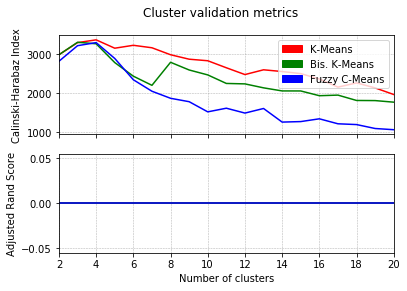

In [29]:
# Data Import
iris, iris_meta = arff.loadarff("datasets/iris.arff")
iris_data = np.array([iris['sepallength'], iris['sepalwidth'],
                      iris['petallength'], iris['petalwidth']]).transpose()
iris_class = iris['class'].reshape((150, 1))


penbased, penbased_meta = arff.loadarff("datasets/pen-based.arff")
penbased_data=np.zeros((len(data), len(data[0])-1))
penbased_class=np.zeros((len(data)))

i=0
for d in data:
    penbased_data[i,:]=[d[0],d[1],d[2],d[3],d[4],d[5],d[6],d[7],d[8],d[9],d[10],d[11],d[12],d[13],d[14],d[15]]
    penbased_class[i]=data[16][0]                
    i=i+1  


def compare_cluster_methods(data, labels_true, k_range=range(2, 21)):

    ch_scores_km = []; ch_scores_bkm = []; ch_scores_fcm = []
    ar_scores_km = []; ar_scores_bkm = []; ar_scores_fcm = []
    _, lab_codes = np.unique(labels_true, return_inverse=True)

    for k in k_range:
        _, labels_km = k_means(k, data)
        labels_bkm = Bk_means(data, k, 0)
        _, _, _, labels_fcm = fcm(data, k)

        ch_scores_km.append(calinski_harabaz_score(data, labels_km))
        ch_scores_bkm.append(calinski_harabaz_score(data, labels_bkm))
        ch_scores_fcm.append(calinski_harabaz_score(data, labels_fcm))

        ar_scores_km.append(adjusted_rand_score(lab_codes, labels_km))
        ar_scores_bkm.append(adjusted_rand_score(lab_codes, labels_bkm))
        ar_scores_fcm.append(adjusted_rand_score(lab_codes, labels_fcm))

    f, (ax1, ax2) = plt.subplots(2, sharex=True)
    f.suptitle('Cluster validation metrics')
    ax1.plot(k_range, ch_scores_km, 'r',
             k_range, ch_scores_bkm, 'g',
             k_range, ch_scores_fcm, 'b')
    ax1.set_ylabel('Calinski-Harabaz Index')
    ax1.grid(linestyle='--', linewidth=0.5)
    ax1.legend(handles=[
        mpatches.Patch(color='r', label='K-Means'),
        mpatches.Patch(color='g', label='Bis. K-Means'),
        mpatches.Patch(color='b', label='Fuzzy C-Means')
    ], loc='upper right')

    ax2.plot(k_range, ar_scores_km, 'r',
             k_range, ar_scores_bkm, 'g',
             k_range, ar_scores_fcm, 'b')
    ax2.set_ylabel('Adjusted Rand Score')
    ax2.set_xlabel('Number of clusters')
    ax2.set_xlim(np.min(k_range), np.max(k_range))
    ax2.grid(linestyle='--', linewidth=0.5)

    plt.show()


#compare_cluster_methods(iris_data, iris_class)
compare_cluster_methods(penbased_data, penbased_class)
